# Investigating why DM and galaxy maps seem to not be right

In [10]:
import sys
sys.path.append('../')
from illustris_frb import exp_simulation, frb_simulation, region

In [11]:
import numpy as np
import pandas as pd
import os
import astropy.units as u 

import matplotlib.pyplot as plt
import healpy as hp

## test ray tracing code 

In [5]:
test_map_path = '/data/submit/submit-illustris/april/data/test_n_e_map'

# ecube = np.zeros((1000,1000,1000))
# ecube[40,40,40] = 1
# np.save(os.path.join(test_map_path, '99.npy'), ecube.flatten())

In [6]:
test_map_path = '/data/submit/submit-illustris/april/data/test_g_map'
# df = pd.DataFrame({'x': [40*205], 'y':[40*205], 'z':[40*205]})
# for i in range(70,100):
#     df.to_hdf(os.path.join(test_map_path, f'{i}_galaxies.hdf5'), key='key')

In [7]:
reg = region(np.array([0,1,0]), -np.arcsin(1/np.sqrt(3)), np.pi/4, res=0.02)

In [8]:
sim = exp_simulation(np.array([1,1,1]), reg, 'debug_test', max_z=0.2,
                     binsize=205, emap_dir=test_map_path, gmap_dir=test_map_path)

In [9]:
sim.comoving_distance(0.4)

1083347.7794183763

### check electrons

In [38]:
sim.compute_DM_grid_partition(nproc=4)

In [22]:
x = sim.comoving_distance(0.2)
nticks = 10*int(x//sim.binsize)+1
xticks = np.linspace(10000, x, nticks)

res = np.load(os.path.join(sim.scratch_path, 'cumulative_DM_000.npy'))
res[:,:,-1]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.37230242e-66, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [23]:
xticks[545]
# THIS IS THE WRONG DISTANCE!!!!!!!!

20977.43092377043

In [24]:
xticks[26574]

545255.5034280281

The problem is that my xticks are given in kpc instead kpc/h, which messes up the interpolation!

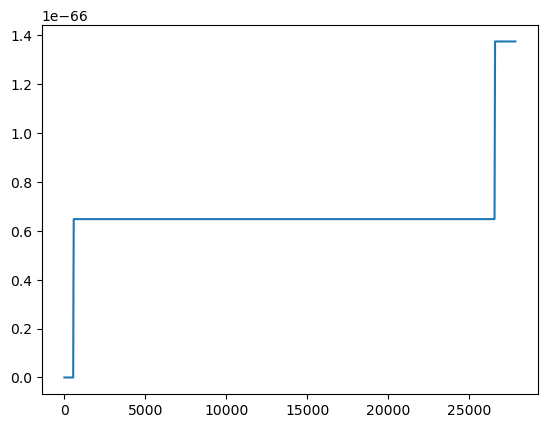

In [17]:
plt.plot(res[2,2,:])

### check galaxies

In [7]:
sim.gcat_from_snaps()

Retrieving galaxies from snapshot 99
        1 periodic box(es) found
Retrieving galaxies from snapshot 98
        1 periodic box(es) found
Retrieving galaxies from snapshot 97
        1 periodic box(es) found
Retrieving galaxies from snapshot 96
        1 periodic box(es) found
Retrieving galaxies from snapshot 95
        1 periodic box(es) found
Retrieving galaxies from snapshot 94
        1 periodic box(es) found
Retrieving galaxies from snapshot 93
        1 periodic box(es) found
Retrieving galaxies from snapshot 92
        1 periodic box(es) found
Retrieving galaxies from snapshot 91
        1 periodic box(es) found
Retrieving galaxies from snapshot 90
        4 periodic box(es) found
Retrieving galaxies from snapshot 89
        7 periodic box(es) found
Retrieving galaxies from snapshot 88
        1 periodic box(es) found
Retrieving galaxies from snapshot 87
        1 periodic box(es) found
Retrieving galaxies from snapshot 86
        1 periodic box(es) found
Retrieving galaxies 

In [8]:
g_counts = sim.Ngal_grid()
g_counts

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [6]:
sim = frb_simulation(origin=np.array([1,1,1]), binsize=205, emap_dir=test_map_path)

In [27]:
sim.comoving_distance(0.2) / sim.boxsize

2.78515507923031

## plot the two maps raw

In [ ]:
snap = 99

# get galaxy cube
df = pd.read_hdf(f'/data/submit/submit-illustris/april/data/g_maps/{snap}_galaxies.hdf5')

binsize = 500
boxsize = 205000
n_bins = int(boxsize/binsize)

df = df[(df['x'] < boxsize) & (df['y'] < boxsize) & (df['z'] < boxsize) ]

inds = (np.array(df['x']) // binsize)*n_bins**2 + \
       (np.array(df['y']) // binsize)*n_bins + \
       (np.array(df['z'])  // binsize)

unique, counts = np.unique(inds, return_counts=True)

g_cube = np.zeros(n_bins**3)
g_cube[unique.astype(int)] += counts
g_cube = g_cube.reshape((n_bins, n_bins, n_bins))

In [29]:
# get electron cube
e_cube = np.load(f'/data/submit/submit-illustris/april/data/n_e_maps/{snap}.npy')
e_cube = e_cube.reshape((n_bins, n_bins, n_bins))

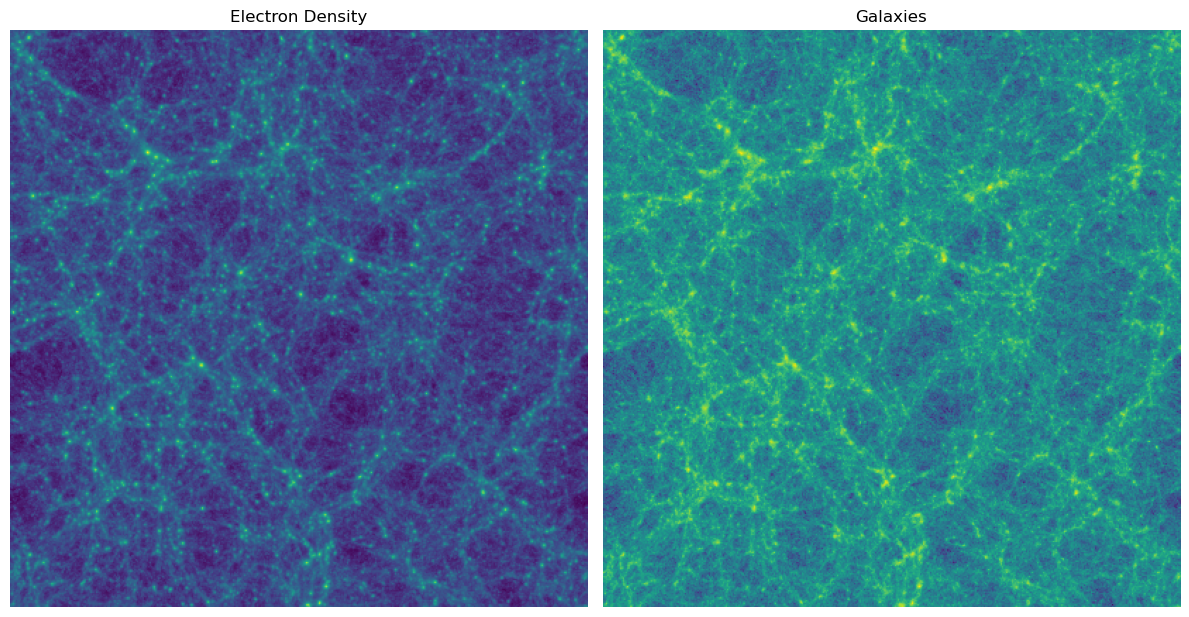

In [51]:
# plot all slices
axis = 2

fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)
axes[0].imshow(np.log(np.sum(e_cube, axis=axis)))
axes[0].set_title('Electron Density')
axes[0].axis('off')

axes[1].imshow(np.log(np.sum(g_cube, axis=axis)))
axes[1].set_title('Galaxies')
axes[1].axis('off')

fig.tight_layout()

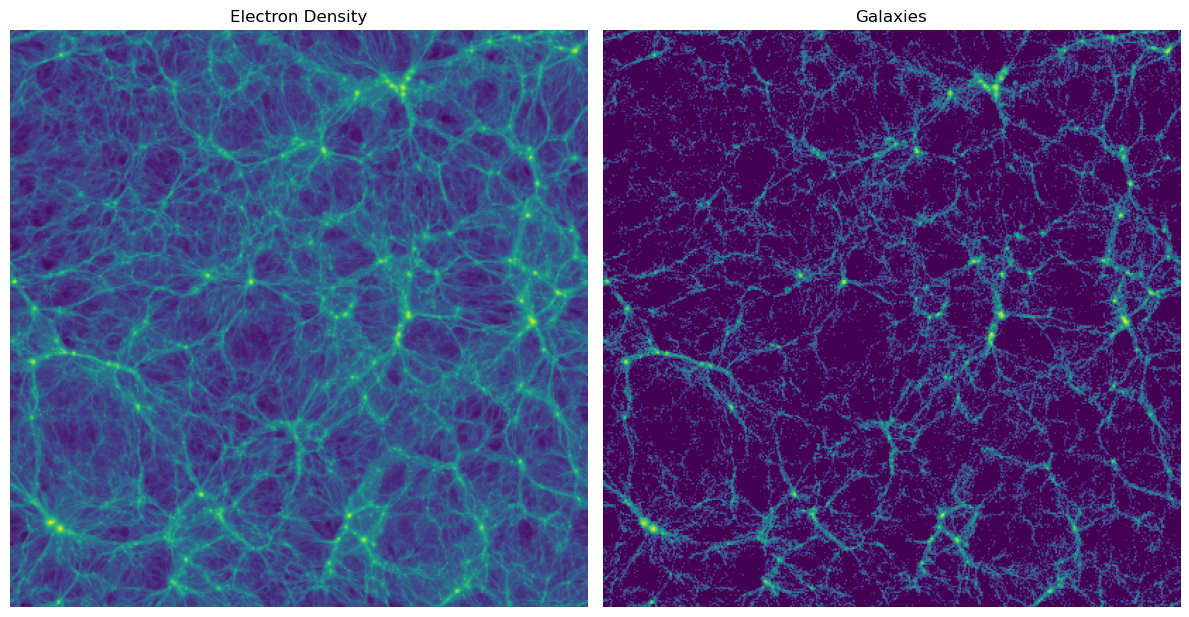

In [55]:
# plot a slice
i=40 
d=10

fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)

e_slice = np.sum(e_cube[:][:][i:i+d], axis=0) 
axes[0].imshow(np.log(e_slice))
axes[0].set_title('Electron Density')
axes[0].axis('off')

g_slice = np.sum(g_cube[:][:][i:i+d], axis=0)
g_slice[ g_slice == 0 ] = 1
axes[1].imshow(np.log(g_slice))
axes[1].set_title('Galaxies')
axes[1].axis('off')

fig.tight_layout()

# Examining region A1 in redshift slices

In [2]:
import sys
sys.path.append('../')
from illustris_frb import exp_simulation, region

import numpy as np
from numpy.linalg import norm
import pandas as pd
import os
import healpy as hp

import matplotlib.pyplot as plt
from matplotlib import rcdefaults

In [3]:
from IPython.display import display, clear_output

In [4]:
origin = 500 * np.array([50, 70, 23])
reg = region((1.18, -np.pi/2), 1.11, 1.88)
region_name = 'A1'
suffix = '_res0008'

sim = exp_simulation(origin, reg, region_name=region_name, suffix=suffix)

In [5]:
def getgrid(xmax, xmin=0, sim=sim, animate=False):
    DMs = sim.DM_grid(xmax, xmin)
    N_gs = sim.Ngal_grid((xmin,xmax))

    # plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)
    axes[0].imshow(DMs)
    axes[0].set_title('DM')
    axes[0].axis('off')

    axes[1].imshow(N_gs)
    axes[1].set_title('Foreground Galaxy Count')
    axes[1].axis('off')

    fig.tight_layout()

    if animate:
        for i in range(10):
            clear_output(wait = True)
            plt.pause(0.1)
            axes[(i+1)%2].imshow(DMs)
            axes[i%2].imshow(N_gs)
            display(fig)
            clear_output(wait = True)
            plt.pause(0.1)
            axes[i%2].imshow(DMs)
            axes[(i+1)%2].imshow(N_gs)
            display(fig)
    return DMs, N_gs

In [5]:
sim.comoving_distance(0.4)/10

108334.77794183763

In [5]:
for i in np.arange(99, 75, -1):
    print(sim.snap_to_xlims(i))

(0.0, 14241.075082328145)
(14241.075082328145, 49977.29331656477)
(49977.29331656477, 85890.22430758236)
(85890.22430758236, 122063.86328610414)
(122063.86328610414, 158408.29252878326)
(158408.29252878326, 195004.20231695194)
(195004.20231695194, 231764.52444763458)
(231764.52444763458, 268766.4264587219)
(268766.4264587219, 305925.92160723044)
(305925.92160723044, 343316.4469180106)
(343316.4469180106, 388409.62567364355)
(388409.62567364355, 426170.3631420393)
(426170.3631420393, 464143.97832893464)
(464143.97832893464, 502255.53232805594)
(502255.53232805594, 540567.8816124545)
(540567.8816124545, 586736.1631666934)
(586736.1631666934, 625366.4187196488)
(625366.4187196488, 664177.0874040693)
(664177.0874040693, 710922.5382431138)
(710922.5382431138, 750016.1765566324)
(750016.1765566324, 797149.560669475)
(797149.560669475, 844403.4414561461)
(844403.4414561461, 883948.8412330769)
(883948.8412330769, 931537.2202875563)


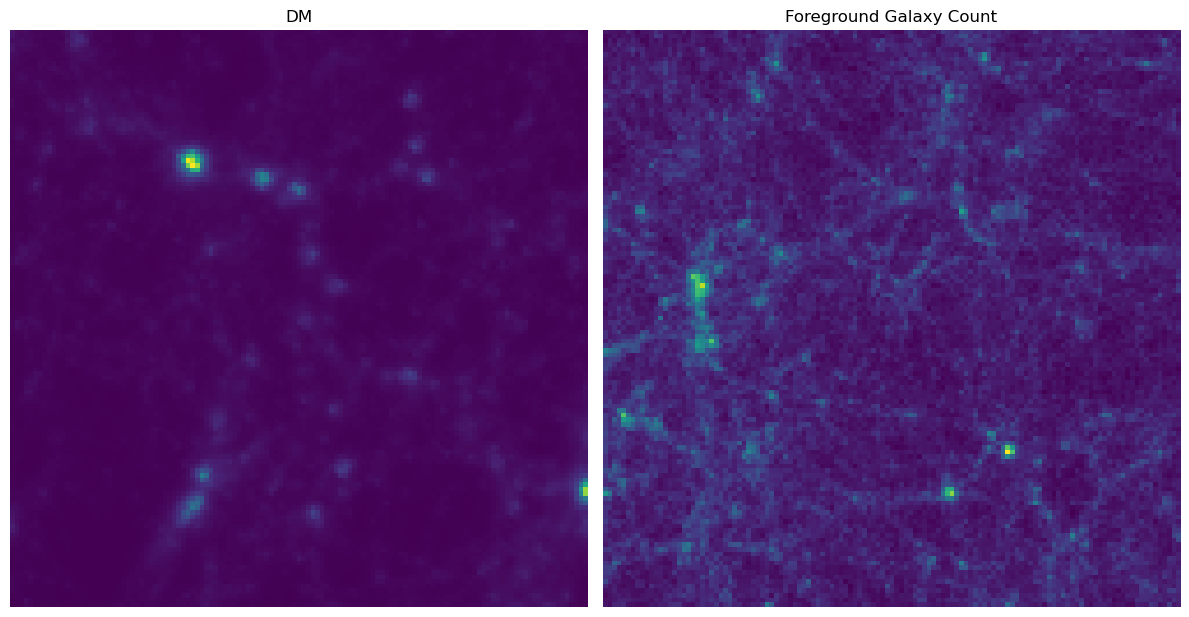

In [8]:
DMs, N_gs = getgrid(6e5, 5e5)

In [9]:
origin = 500 * np.array([50, 70, 23])
reg = region((0, 0), 0, 0.1, size=0.18, res=0.001)
region_name = 'confirm_test'
suffix = '_res001'
simtest = exp_simulation(origin, reg, region_name=region_name, suffix=suffix)

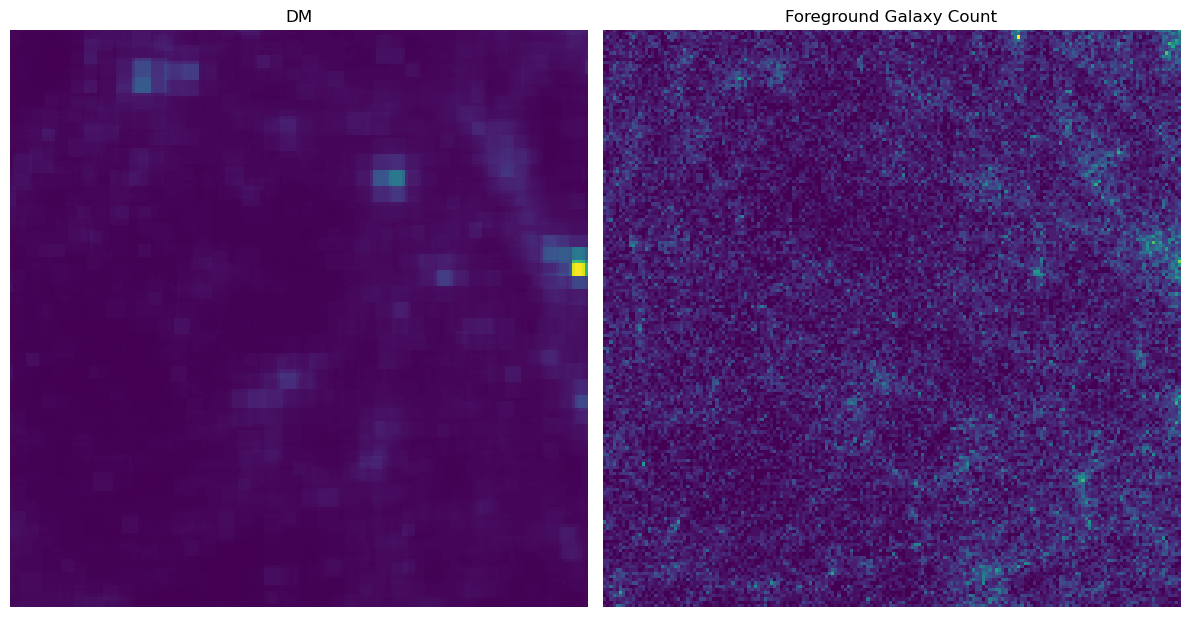

In [13]:
DMs, N_gs = getgrid(2e5, 1e5, sim=simtest)

In [7]:
np.amax(N_gs)

0.0

In [9]:
sim.comoving_distance(sim.max_z)

1083347.7794183763

In [5]:
sim.snap_to_xlims(99)

(0.0, 14241.075082328145)

# Debugging: why is the ray traced DM map offset from the galaxy map?

In [1]:
import numpy as np
import pandas as pd
import os
from astropy import units as u

import sys
sys.path.append('../')
from illustris_frb import frb_simulation, simulation

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [6]:
from illustris_frb.utils import rotate_to_0, rotate_to_1

In [24]:
np.longdouble(2)

2.0

In [42]:
v = np.array([[1,0,0],
              [5,0,0],
              [10,0,0]])
k = np.array((1,2,3))
np.cross(k, v)

array([[  0,   3,  -2],
       [  0,  15, -10],
       [  0,  30, -20]])

In [44]:
print([np.cross(k, v_) for v_ in v])

[array([ 0,  3, -2]), array([  0,  15, -10]), array([  0,  30, -20])]


In [29]:
phi1s = []
for phi1 in np.arange(0, 2*np.pi, 0.2):
    theta0, phi0 = rotate_to_0(np.pi/2, phi1, 0.1, 0)
    theta1, phi1 = rotate_to_1(theta0, phi0, 0.1, 0)
    phi1s.append(phi1)

(-0.1, 0.1)

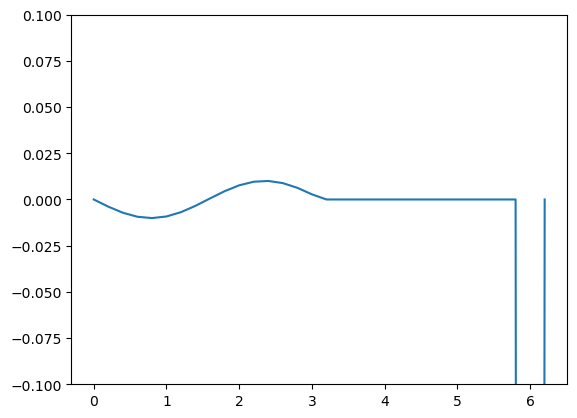

In [32]:
plt.plot(np.arange(0, 2*np.pi, 0.2), np.array(phi1s) - np.arange(0, 2*np.pi, 0.2))
plt.ylim(-0.1,0.1)

(1.7137998874268958, 0.7899346272167872)

In [13]:
np.pi/2

1.5707963267948966

In [2]:
datapath = '/data/submit/submit-illustris/april/data/results'
figpath = '/home/submit/aqc/frb_project/figures'

In [ ]:
sim = simulation('L205n2500TNG')

In [128]:
print((sim.cosmo.kpc_comoving_per_arcmin(0.4)*(0.18*u.rad)).to(u.kpc))
print((sim.boxsize * u.kpc / sim.h))

# laterally we are only looking at one simulation box

287869.20622277487 kpc
302627.69412459404 kpc


In [130]:
print(sim.cosmo.comoving_distance(0.4).to(u.kpc).value / (sim.boxsize / sim.h)) #number of simulation boxes

5.284623314235982


### z=0.2 shell

In [3]:
df = pd.read_hdf(os.path.join(datapath, 'debugshell_z02.hdf5'))
df

DM  N_g
0       66.708277  132
1       37.090387   79
2       45.686083   67
3       29.519959   55
4       28.181216   48
...           ...  ...
32395   58.997299  103
32396  101.983362  132
32397  107.614813  115
32398   83.565625  115
32399   71.446464  127

[32400 rows x 2 columns]

In [4]:
shape = np.array((180,180))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1

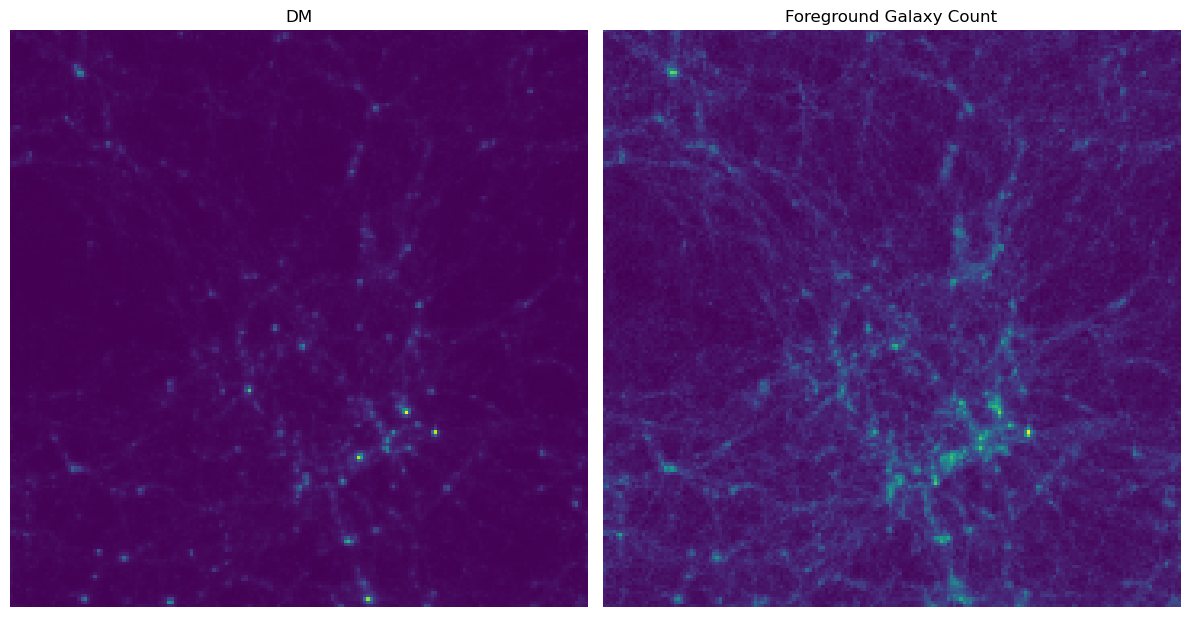

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)

axes[0].imshow(DMs)
axes[0].set_title('DM')
axes[0].axis('off')

axes[1].imshow(N_gs)
axes[1].set_title('Foreground Galaxy Count')
axes[1].axis('off')

plt.tight_layout()
# plt.savefig(os.path.join(figpath, 'test_flat_res001_shell_heatmap.png'), bbox_inches='tight')

In [5]:
df[df['DM']<0]

DM  N_g
5       -14.910758   40
15     -156.070230   66
16    -1156.890194   56
17     -300.669852   35
18     -215.815407   20
...            ...  ...
32383  -121.580622  104
32384 -2954.921534  114
32391   -13.889238   60
32398  -925.276212  115
32399 -1292.876903  127

[8836 rows x 2 columns]

## preliminary tests

### electron density map vs counts map

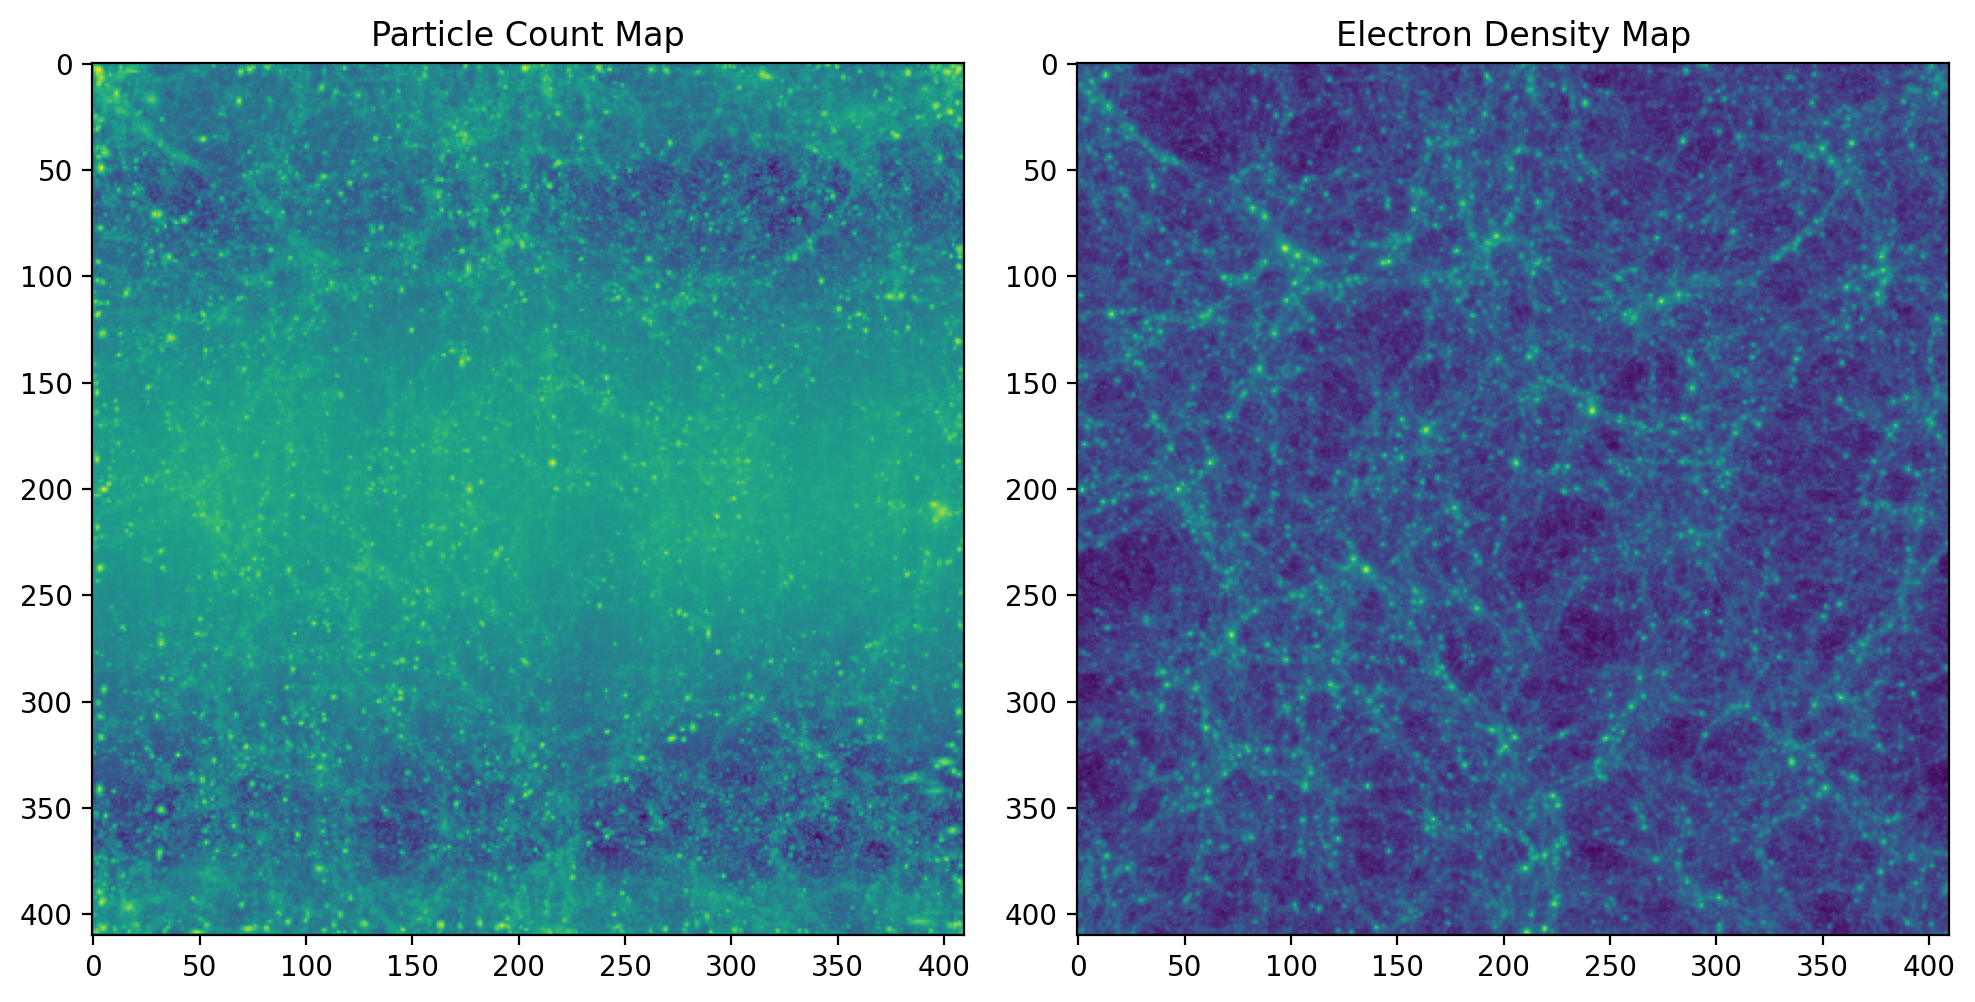

In [1]:
# I had to do this on illustris, but here's the figure

from IPython.display import Image
Image(filename='figures/e_map_comparison.png') 

The electron density map is created correctly 

### electron density map vs ray tracing 

In [4]:
sim = frb_simulation('L205n2500TNG')
N = 50

grid = np.array(np.meshgrid(np.arange(N), np.arange(N))).T.reshape(N**2, 2)
grid = grid*(sim.boxsize/N) + (sim.boxsize/N)/2
grid = np.hstack((grid, np.zeros((N**2, 1))))

In [6]:
DMs = []
for origin in grid:
    sim = frb_simulation('L205n2500TNG', origin=origin)
    dest = origin + np.array([0,0,sim.boxsize])
    DMs.append(sim.get_frb_DM(dest).value)


In [7]:
np.save('debug_DM_grid.npy', np.array(DMs))

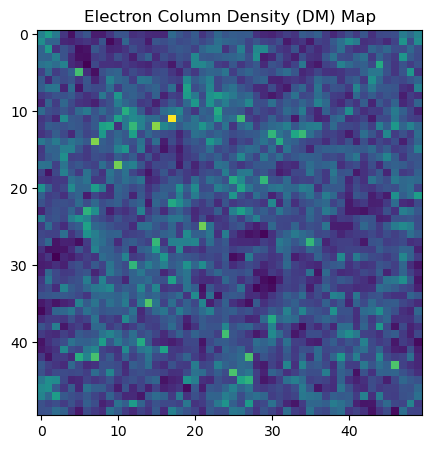

In [9]:
DMs = np.array(DMs).reshape((N,N))
fig = plt.figure(figsize=(5,5))
plt.imshow(DMs, norm=LogNorm())
plt.title('Electron Column Density (DM) Map')
plt.savefig('../figures/DM_map.png', dpi=200)

### Galaxy map 

In [12]:
g_df = pd.read_hdf('../data/g_maps/99_galaxies.hdf5')
g_df

x              y              z           Mass  SFR  \
0          44003.539062   49335.136719  147348.671875  128334.601562  0.0   
1          45421.101562   51842.078125  146393.109375   36333.289062  0.0   
2          44488.332031   49092.589844  147870.812500     896.404297  0.0   
3          43819.976562   50933.199219  147711.140625     494.986298  0.0   
4          44303.148438   49630.011719  147869.000000     467.464050  0.0   
...                 ...            ...            ...            ...  ...   
14435606  199774.828125  105178.773438  117246.093750       0.103569  0.0   
14435607  196450.437500    9943.825195  184929.953125       0.107553  0.0   
14435608  197119.390625  130806.460938  128707.078125       0.107553  0.0   
14435609  203048.328125    5476.173828   41676.285156       0.103569  0.0   
14435610  197566.109375  171985.968750   58273.031250       0.111536  0.0   

              Radius  
0         940.981323  
1         476.462219  
2          73.835571  
3          75.418587  
4          62.782177  
...              ...  
14435606   10.532459  
14435607   10.443684  
14435608    6.513499  
14435609    8.920770  
14435610    8.783834  

[14435611 rows x 6 columns]

In [13]:
H, _, _ = np.histogram2d(g_df['x'], g_df['y'], bins=np.arange(0, ))

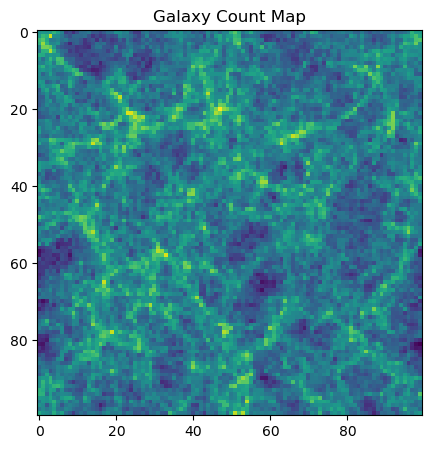

In [15]:
fig = plt.figure(figsize=(5,5))
plt.imshow(H, norm=LogNorm())
plt.title('Galaxy Count Map')
plt.savefig('../figures/N_gal_map.png', dpi=200)